# Inference: Haario-Bardenet adaptive covariance MCMC

This example shows you how to perform Bayesian inference on a time series, using a variant of [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc_remi.html) detailed in supplementary materials of [1].

[1] Uncertainty and variability in models of the cardiac action potential:
    Can we build trustworthy models?
    Johnstone, Chang, Bardenet, de Boer, Gavaghan, Pathmanathan, Clayton,
    Mirams (2015) Journal of Molecular and Cellular Cardiology

It follows on from the [first sampling example](./sampling-first-example.ipynb).

Running...
Done!
R-hat:
[1.0059906232479283, 1.0050963083895565, 1.0052273173473436]


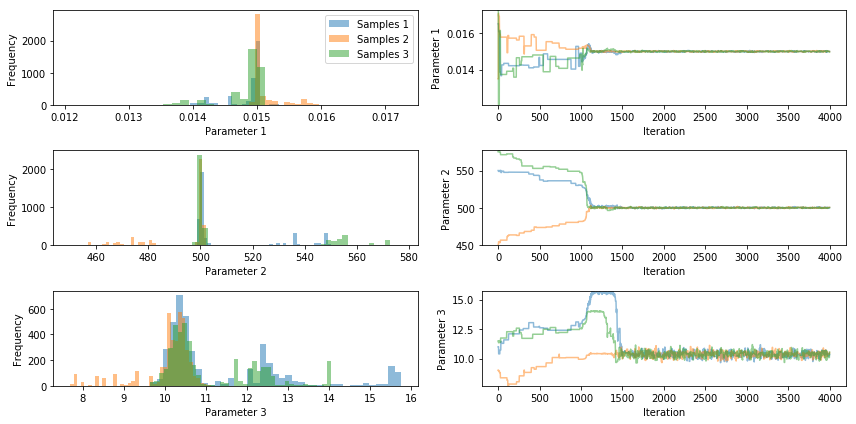

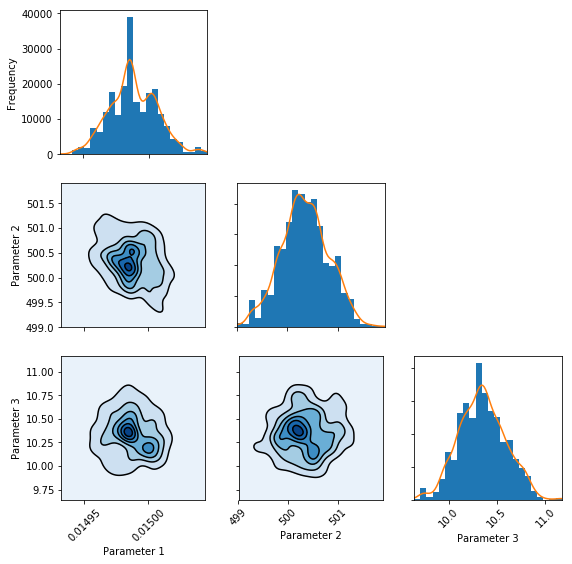

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import time

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Create mcmc routine with four chains
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# time start
start = time.time()

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# end time
end = time.time()
time = end - start

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)

# Show graphs
plt.show()

Use a results object to tabulate parameter-specific results.

In [4]:
results = pints.MCMCResults(chains, time, parameter_names=["r", "k", "sigma"])
results.print_summary()

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
r        0.01    0.00    0.01    0.01    0.01    0.02    0.02     1.01    513.47  63.18
k        500.29  0.47    499.36  499.96  500.29  500.62  501.20   1.01    482.79  59.40
sigma    10.36   0.23    9.92    10.21   10.36   10.52   10.80    1.01    479.30  58.97
